# 多分类问题与通用训练函数

**Softmax函数：** 将输出值映射到0-1之间，并且所有输出的和为1，常用于多分类问题。当只有两个类别时，对数几率函数和softmax函数是等价的。

**pytorch交叉熵：** 对于多分类问题，pytorch提供了交叉熵函数（nn.CrossEntropyLoss和nn.NLLLoss），其中nn.CrossEntropyLoss内部实现了softmax函数，并且对标签值进行了one-hot编码，而nn.NLLLoss需要手动添加softmax函数。

In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 预处理数据

In [2]:
# 数据集，鸢尾花数据集
data = pd.read_csv('./dataset/iris.csv')
data.head()

,Unnamed: 0,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
0,1,5.1,3.5,1.4,0.2,setosa
1,2,4.9,3.0,1.4,0.2,setosa
2,3,4.7,3.2,1.3,0.2,setosa
3,4,4.6,3.1,1.5,0.2,setosa
4,5,5.0,3.6,1.4,0.2,setosa


In [3]:
print(data.Species.unique())
print(pd.factorize(data.Species))

['setosa' 'versicolor' 'virginica']
(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int64), Index(['setosa', 'versicolor', 'virginica'], dtype='object'))


In [4]:
data['Species'] = pd.factorize(data.Species)[0] # 将标签值转换为数字
data

,Unnamed: 0,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
0,1,5.1,3.5,1.4,0.2,0
1,2,4.9,3.0,1.4,0.2,0
2,3,4.7,3.2,1.3,0.2,0
3,4,4.6,3.1,1.5,0.2,0
4,5,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...,...
145,146,6.7,3.0,5.2,2.3,2
146,147,6.3,2.5,5.0,1.9,2
147,148,6.5,3.0,5.2,2.0,2
148,149,6.2,3.4,5.4,2.3,2


In [5]:
# 分离特征值和标签值
X = data.iloc[:, 1: -1].values # 特征值
print(X.shape)
Y = data.Species.values # 标签值
print(Y.shape)

(150, 4)
(150,)


In [6]:
# 划分训练集和测试集
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(X, Y)
# 数据归一化，ndarray转换为tensor
train_x = torch.from_numpy(train_x).type(torch.FloatTensor)
train_y = torch.from_numpy(train_y).type(torch.LongTensor)
test_x = torch.from_numpy(test_x).type(torch.FloatTensor)
test_y = torch.from_numpy(test_y).type(torch.LongTensor)

In [7]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

print("data_len = " + str(len(data)))
batch = 8

train_ds = TensorDataset(train_x, train_y)
train_dl = DataLoader(train_ds, batch_size=batch, shuffle=True)

test_ds = TensorDataset(test_x, test_y)
test_dl = DataLoader(test_ds, batch_size=batch)

print("train_len = " + str(len(train_dl.dataset)))

data_len = 150
train_len = 112


## 创建模型

In [8]:
from torch import nn
import torch.nn.functional as F # 函数式API，调用方便使代码更简洁
class Model(nn.Module):  # 继承nn.Module
    def __init__(self):     # 初始化所有的层
        super().__init__()  # 继承父类中所有的属性和方法
        self.lin_1 = nn.Linear(4, 32)  # 定义第一层线性层，输入维度为4，输出维度为32
        self.lin_2 = nn.Linear(32, 32)  # 定义第二层线性层，输入维度为32，输出维度为32
        self.lin_3 = nn.Linear(32, 3)   # 定义第三层线性层，输入维度为32，输出维度为3
    def forward(self, input):   # 前向传播函数，定义模型的运算过程，覆盖父类中的forward方法
        x = F.relu(self.lin_1(input))   # 将输入数据传入第一层线性层，并使用ReLU激活函数
        x = F.relu(self.lin_2(x))       # 将激活后的数据传入第二层线性层，并使用ReLU激活函数
        x = self.lin_3(x)               # 多分类问题，最后一层不需要激活函数
        return x

# 实例化模型
model = Model()
model

Model(
  (lin_1): Linear(in_features=4, out_features=32, bias=True)
  (lin_2): Linear(in_features=32, out_features=32, bias=True)
  (lin_3): Linear(in_features=32, out_features=3, bias=True)
)

In [9]:
# 损失函数
loss_fn = nn.CrossEntropyLoss()

In [10]:
# 理解模型的预测结果
# 获取一个batch的数据
input_batch, label_batch = next(iter(train_dl)) # iter()函数返回一个迭代器，next()函数返回一个批次的张量
print(input_batch.shape, label_batch.shape)
# 前向传播
y_pred = model(input_batch)
print(y_pred.shape)
print(y_pred)
# 查看预测结果
print(torch.argmax(y_pred, dim=1)) # argmax()函数返回张量中最大值的索引，dim=1表示在每一行中找到最大值的索引

torch.Size([8, 4]) torch.Size([8])
torch.Size([8, 3])
tensor([[ 0.1757, -0.1786, -0.1753],
        [ 0.1669, -0.1380, -0.1407],
        [ 0.2091, -0.3070, -0.2567],
        [ 0.1826, -0.1821, -0.1720],
        [ 0.2275, -0.2655, -0.2068],
        [ 0.2229, -0.2603, -0.2097],
        [ 0.2298, -0.2643, -0.2157],
        [ 0.2476, -0.3070, -0.2238]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 0, 0, 0, 0, 0])


## 创建训练函数

In [11]:
# 准确率计算函数，用于计算预测值和真实值之间的准确率
def accuracy(y_pred, y_true):
    # 按照行取最大值，返回最大值的索引，即预测值
    y_pred = torch.argmax(y_pred, dim=1)
    # 计算预测值和真实值相等的数量的均值，并转换为浮点数
    return (y_pred == y_true).float().mean()

In [12]:
# 训练模型
# 定义结果存放列表
train_loss = []
train_acc = []
test_loss = []
test_acc = []

# 设置训练的轮数
epochs = 100

# 定义优化器
opt = torch.optim.Adam(model.parameters(), lr=0.0001)

for epoch in range(epochs):
    for x, y in train_dl:
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        opt.zero_grad()
        loss.backward()
        opt.step()
    with torch.no_grad():
        epoch_acc = accuracy(model(train_x), train_y).data.item()
        epoch_loss = loss_fn(model(train_x), train_y).data.item()

        epoch_test_acc = accuracy(model(test_x), test_y).data.item()
        epoch_test_loss = loss_fn(model(test_x), test_y).data.item()
        print('epoch:', epoch, '   ', 'loss:', round(epoch_loss, 3),
                               '   ', 'acc:', round(epoch_acc, 3),
                               '   ', 'test_loss:', round(epoch_test_loss, 3),
                               '   ', 'test_acc:', round(epoch_test_acc, 3))
        # 将结果存入列表
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)
        test_loss.append(epoch_test_loss)
        test_acc.append(epoch_test_acc)

epoch: 0     loss: 1.136     acc: 0.321     test_loss: 1.128     test_acc: 0.368
epoch: 1     loss: 1.117     acc: 0.321     test_loss: 1.111     test_acc: 0.368
epoch: 2     loss: 1.098     acc: 0.321     test_loss: 1.097     test_acc: 0.368
epoch: 3     loss: 1.08     acc: 0.321     test_loss: 1.082     test_acc: 0.368
epoch: 4     loss: 1.064     acc: 0.402     test_loss: 1.067     test_acc: 0.421
epoch: 5     loss: 1.049     acc: 0.741     test_loss: 1.054     test_acc: 0.632
epoch: 6     loss: 1.036     acc: 0.732     test_loss: 1.041     test_acc: 0.605
epoch: 7     loss: 1.025     acc: 0.696     test_loss: 1.033     test_acc: 0.579
epoch: 8     loss: 1.016     acc: 0.696     test_loss: 1.025     test_acc: 0.579
epoch: 9     loss: 1.007     acc: 0.696     test_loss: 1.017     test_acc: 0.579
epoch: 10     loss: 0.998     acc: 0.696     test_loss: 1.011     test_acc: 0.579
epoch: 11     loss: 0.989     acc: 0.696     test_loss: 1.001     test_acc: 0.579
epoch: 12     loss: 0.981  

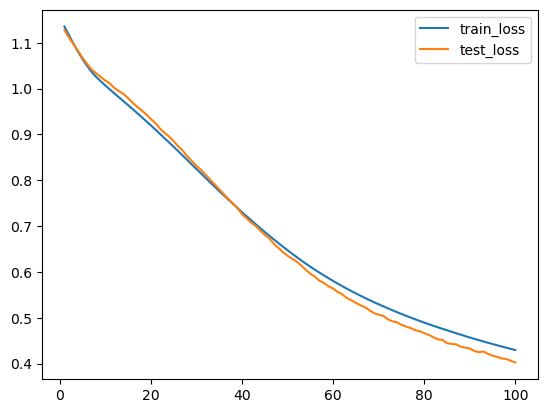

In [13]:
plt.plot(range(1, epochs+1), train_loss, label='train_loss') # 绘制训练损失曲线
plt.plot(range(1, epochs+1), test_loss, label='test_loss') # 绘制测试损失曲线
plt.legend() # 显示图例

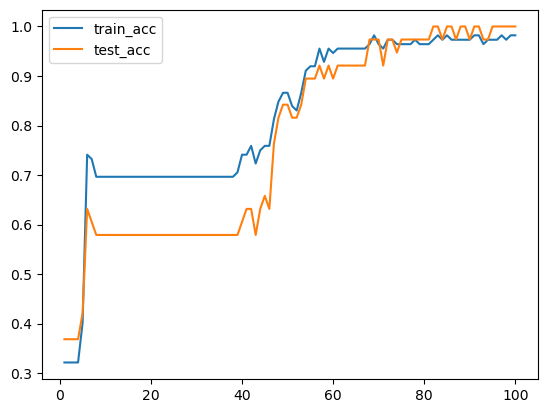

In [14]:
plt.plot(range(1, epochs+1), train_acc, label='train_acc')
plt.plot(range(1, epochs+1), test_acc, label='test_acc')
plt.legend()

## 通用训练模板

编写一个fit函数，输入模型、输入数据（train_dl, test_dl），对数据输入在模型上训练，并且返回loss和acc变化

In [15]:
# 训练函数，输入模型、训练数据、测试数据，返回loss和acc变化
def fit(epoch, model, trainloader, testloader):
    # 模型训练，记录模型在训练集上的loss和acc
    correct = 0
    total = 0
    running_loss = 0
    for x, y in trainloader:
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        opt.zero_grad()
        loss.backward()
        opt.step()
        with torch.no_grad():
            y_pred = torch.argmax(y_pred, dim=1)    # 按照行取最大值，返回最大值的索引，即预测值
            correct += (y_pred == y).sum().item()   # 计算每个batch中预测正确的数量，并累加到correct变量中得到每个epoch中预测正确的数量
            total += y.size(0)                      # 计算每个batch中样本的数量，并累加到total变量中得到每个epoch中样本的总数
            running_loss += loss.item()             # 计算每个batch中损失，并累加到running_loss变量中得到每个epoch中损失的总和
        
    epoch_loss = running_loss / len(trainloader.dataset)    # 每个epoch中损失的总和除以总样本数，得到每个epoch的平均损失
    epoch_acc = correct / total                             # 计算每个epoch中预测正确的数量占总数的比例，即准确率
        
    # 模型测试，记录模型在测试集上的loss和acc
    test_correct = 0
    test_total = 0
    test_running_loss = 0
    with torch.no_grad():
        for x, y in testloader:
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            y_pred = torch.argmax(y_pred, dim=1)
            test_correct += (y_pred == y).sum().item()
            test_total += y.size(0)
            test_running_loss += loss.item()
    
    epoch_test_loss = test_running_loss / len(testloader.dataset)
    epoch_test_acc = test_correct / test_total
    
        
    print('epoch: ', epoch, 
   '   ', 'loss: ', round(epoch_loss, 3),
   '   ', 'acc:', round(epoch_acc, 3),
   '   ', 'test_loss: ', round(epoch_test_loss, 3),
   '   ', 'test_acc:', round(epoch_test_acc, 3))
        
    return epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc

1. 创建输入（dataloader）
2. 创建模型（model）
3. 创建损失函数
4. 创建优化器

In [16]:
model = Model()
opt = torch.optim.Adam(model.parameters(), lr=0.0001)

train_loss = []
train_acc = []
test_loss = []
test_acc = []

epochs = 100

for epoch in range(epochs):
    epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc = fit(epoch, model, train_dl, test_dl)
    
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)

epoch:  0     loss:  0.139     acc: 0.375     test_loss:  0.151     test_acc: 0.211
epoch:  1     loss:  0.137     acc: 0.375     test_loss:  0.149     test_acc: 0.211
epoch:  2     loss:  0.136     acc: 0.375     test_loss:  0.147     test_acc: 0.211
epoch:  3     loss:  0.135     acc: 0.375     test_loss:  0.144     test_acc: 0.211
epoch:  4     loss:  0.133     acc: 0.375     test_loss:  0.143     test_acc: 0.211
epoch:  5     loss:  0.132     acc: 0.375     test_loss:  0.141     test_acc: 0.211
epoch:  6     loss:  0.131     acc: 0.375     test_loss:  0.14     test_acc: 0.211
epoch:  7     loss:  0.13     acc: 0.375     test_loss:  0.138     test_acc: 0.211
epoch:  8     loss:  0.129     acc: 0.375     test_loss:  0.137     test_acc: 0.263
epoch:  9     loss:  0.128     acc: 0.393     test_loss:  0.136     test_acc: 0.289
epoch:  10     loss:  0.127     acc: 0.411     test_loss:  0.134     test_acc: 0.421
epoch:  11     loss:  0.126     acc: 0.571     test_loss:  0.132     test_acc

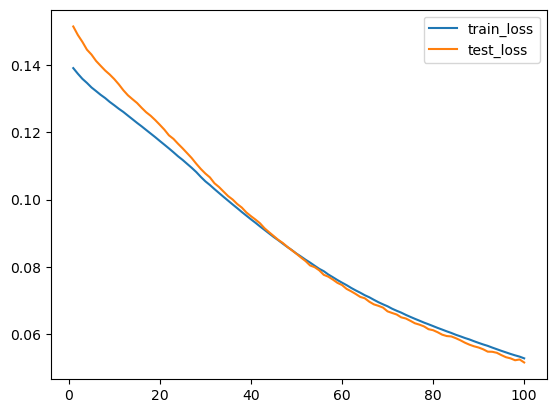

In [17]:
plt.plot(range(1, epochs+1), train_loss, label='train_loss')
plt.plot(range(1, epochs+1), test_loss, label='test_loss')
plt.legend()

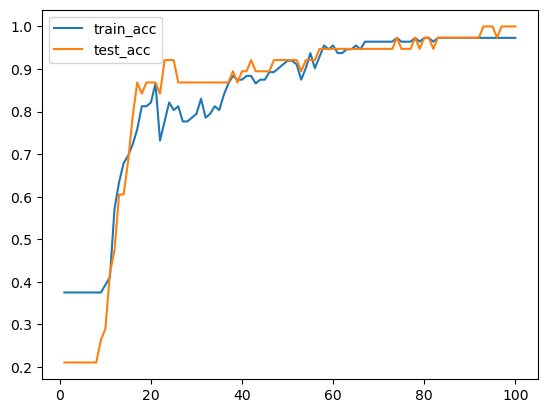

In [18]:
plt.plot(range(1, epochs+1), train_acc, label='train_acc')
plt.plot(range(1, epochs+1), test_acc, label='test_acc')
plt.legend()